# Proyek Klasifikasi Gambar: [Vehicle Image Classification]
- **Nama:** [Ismi Nilam Anggraini]
- **Email:** [isminilamng@gmail.com]
- **ID Dicoding:** [isminilam]

**Sumber Dataset:**
https://www.kaggle.com/datasets/matthewlim8/vehicle-image-classification/data

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"isminilamanggraini","key":"a43db4b150b7a3f5ac3e563e01624a14"}'}

In [4]:
# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d matthewlim8/vehicle-image-classification
!unzip vehicle-image-classification.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Motorcycle/Bike (1273).jpeg  
  inflating: Motorcycle/Bike (1274).jpeg  
  inflating: Motorcycle/Bike (1275).jpeg  
  inflating: Motorcycle/Bike (1276).jpeg  
  inflating: Motorcycle/Bike (1277).jpeg  
  inflating: Motorcycle/Bike (1278).jpeg  
  inflating: Motorcycle/Bike (1279).jpeg  
  inflating: Motorcycle/Bike (128).jpeg  
  inflating: Motorcycle/Bike (128).jpg  
  inflating: Motorcycle/Bike (1280).jpeg  
  inflating: Motorcycle/Bike (1281).jpeg  
  inflating: Motorcycle/Bike (1282).jpeg  
  inflating: Motorcycle/Bike (1283).jpeg  
  inflating: Motorcycle/Bike (1284).jpeg  
  inflating: Motorcycle/Bike (1285).jpeg  
  inflating: Motorcycle/Bike (1286).jpeg  
  inflating: Motorcycle/Bike (1287).jpeg  
  inflating: Motorcycle/Bike (1288).jpeg  
  inflating: Motorcycle/Bike (1289).jpeg  
  inflating: Motorcycle/Bike (129).jpeg  
  inflating: Motorcycle/Bike (129).jpg  
  inflating: Motorcycle/Bike (1290).jpeg  
 

In [5]:
# Mengatur direktori awal untuk tiap label kendaraan
car_dir = "/content/Car"
motorcycle_dir = "/content/Motorcycle"
truck_dir = "/content/Truck"
van_dir = "/content/Van"

# Mengatur direktori baru untuk dataset gabungan
combined_dir = "vehicles_dataset"
os.makedirs(combined_dir, exist_ok=True)

# Fungsi untuk menyalin gambar dari folder asal ke folder target
def copy_images(source_dir, target_label, max_count=None):
    target_dir = os.path.join(combined_dir, target_label)
    os.makedirs(target_dir, exist_ok=True)

    count = 0
    for img in os.listdir(source_dir):
        if img.lower().endswith(('.jpg', '.jpeg', '.png')):
            source_path = os.path.join(source_dir, img)
            target_path = os.path.join(target_dir, img)

            if os.path.isfile(source_path):
                shutil.copy(source_path, target_path)
                count += 1
                if max_count and count >= max_count:
                    break

# Menyalin gambar (car dibatasi menjadi 5000 gambar)
copy_images(car_dir, "car", max_count=5000)
copy_images(motorcycle_dir, "motorcycle")
copy_images(truck_dir, "truck")
copy_images(van_dir, "van")

## **Plot gambar sampel untuk semua kelas**

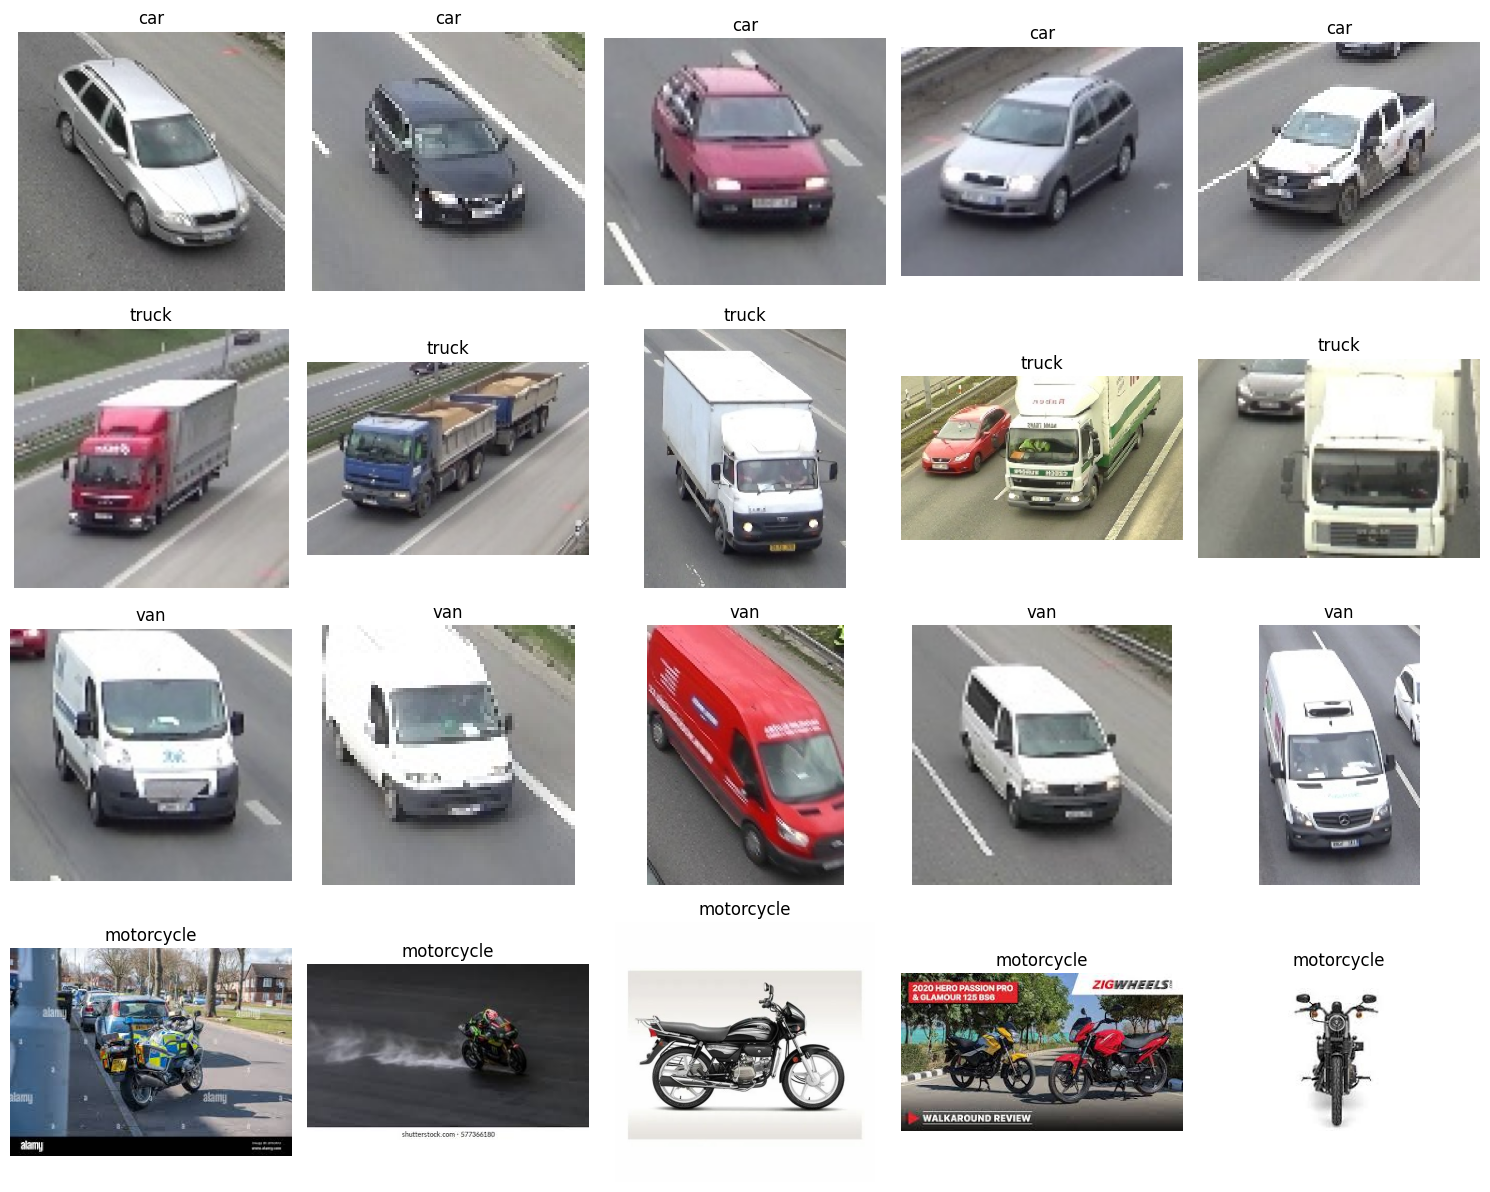

In [6]:
# Membuat kamus yang menyimpan daftar gambar untuk setiap kelas kendaraan
vehicle_images = {}

# Path ke folder dataset gabungan
path_sub = "vehicles_dataset"

# Membaca semua gambar per kelas
for class_name in os.listdir(path_sub):
    class_path = os.path.join(path_sub, class_name)
    vehicle_images[class_name] = os.listdir(class_path)

# Menampilkan secara acak 5 gambar dari setiap kelas
fig, axs = plt.subplots(len(vehicle_images.keys()), 5, figsize=(15, 12))

for i, class_name in enumerate(vehicle_images.keys()):
    images = np.random.choice(vehicle_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # Gambar berwarna
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## **Plot distribusi gambar sebelum augmentasi**

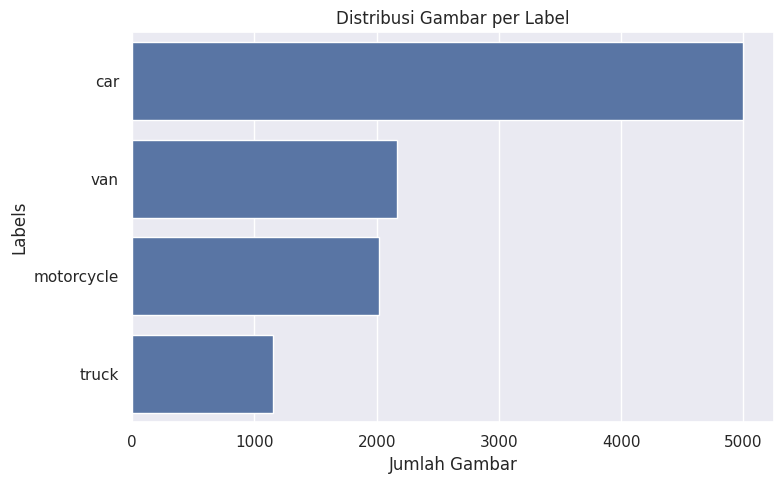

In [7]:
sns.set(style="darkgrid")

# Source path
vehicle_path = "vehicles_dataset/"

file_name = []
labels = []
full_path = []

# Mendapatkan data image filenames, filepaths, labels dengan looping, dan simpan dalam dataframe
for path, subdirs, files in os.walk(vehicle_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Hitung jumlah gambar per label
label_counts = df['labels'].value_counts()

# Plot bar horizontal
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.values, y=label_counts.index)
plt.xlabel("Jumlah Gambar")
plt.ylabel("Labels")
plt.title("Distribusi Gambar per Label")
plt.tight_layout()
plt.show()

Data Augmentasi

In [8]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

# Resize helper
def resize_image(img, size=(224, 224)):
    return tf.image.resize(img, size)

# Rotasi berlawanan arah jarum jam (anticlockwise)
def anticlockwise_rotation(img):
    img = resize_image(img)
    img = tf.image.rot90(img, k=random.randint(1, 4))  # 90, 180, 270, atau 360 derajat
    return img

# Rotasi searah jarum jam (clockwise)
def clockwise_rotation(img):
    img = resize_image(img)
    img = tf.image.rot90(img, k=random.randint(1, 4))  # 90, 180, 270, atau 360 derajat
    return img

# Flip vertikal
def flip_up_down(img):
    img = resize_image(img)
    img = tf.image.flip_up_down(img)
    return img

# Penyesuaian kecerahan gambar
def add_brightness(img):
    img = resize_image(img)
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Menyesuaikan kecerahan secara acak
    return img

# Pergeseran gambar (warp shift)
def warp_shift(img):
    img = resize_image(img)
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Efek shearing (miring)
def sheared(img):
    img = resize_image(img)
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Fungsi untuk memastikan gambar berada dalam rentang yang valid (0-255 untuk uint8)
def validate_and_convert(img):
    img = tf.clip_by_value(img, 0, 255)  # Memastikan nilai pixel berada antara 0 dan 255
    img = tf.cast(img, tf.uint8)  # Mengubah tipe data menjadi uint8
    return img

In [9]:
import tensorflow as tf
import os
import random
from PIL import Image
import cv2
import numpy as np
from skimage import img_as_ubyte

# Fungsi transformasi augmentasi
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

# Fungsi untuk memastikan gambar dalam rentang yang valid (0-255)
def validate_and_convert(img):
    img = tf.clip_by_value(img, 0, 255)  # Memastikan nilai pixel berada antara 0 dan 255
    img = tf.cast(img, tf.uint8)  # Mengubah tipe data menjadi uint8
    return img

#  Daftar Kelas Target
target_classes = ['van', 'truck', 'motorcycle']
base_path = "vehicles_dataset"
images_to_generate = 3500

for class_name in target_classes:
    images_path = os.path.join(base_path, class_name)

    # Membaca gambar-gambar di dalam folder kelas
    images = [os.path.join(images_path, img) for img in os.listdir(images_path)
              if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    print(f"[INFO] Augmenting class '{class_name}' ({len(images)} original images)...")

    i = 1
    while i <= images_to_generate:
        image_path = random.choice(images)
        try:
            # Baca gambar dengan PIL dan ubah menjadi array
            img_pil = Image.open(image_path).convert("RGB")
            img_array = tf.keras.utils.img_to_array(img_pil)

            transformed_image = img_array
            transformation_count = random.randint(1, len(transformations))  # Tentukan berapa banyak transformasi yang diterapkan

            # Terapkan transformasi secara acak
            for _ in range(transformation_count):
                key = random.choice(list(transformations.keys()))
                transformed_image = transformations[key](transformed_image)

            # Validasi dan konversi gambar yang sudah ditransformasikan
            transformed_image = validate_and_convert(transformed_image)

            # Menyimpan gambar hasil augmentasi ke folder yang sesuai
            output_filename = f"{class_name}_augment_{i:04d}.jpg"
            output_path = os.path.join(images_path, output_filename)

            # Mengonversi gambar menjadi format yang benar
            transformed_image = img_as_ubyte(transformed_image)
            cv2.imwrite(output_path, transformed_image)
            i += 1

        except Exception as e:
            print(f"[ERROR] Failed to process {image_path}: {e}")

    print(f"[DONE] {class_name} -> {images_to_generate} augmented images saved to '{images_path}'\n")

[INFO] Augmenting class 'van' (2167 original images)...
[DONE] van -> 3500 augmented images saved to 'vehicles_dataset/van'

[INFO] Augmenting class 'truck' (1150 original images)...
[DONE] truck -> 3500 augmented images saved to 'vehicles_dataset/truck'

[INFO] Augmenting class 'motorcycle' (2021 original images)...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[DONE] motorcycle -> 3500 augmented images saved to 'vehicles_dataset/motorcycle'



## **Plot distribusi gambar setelah augmentasi**

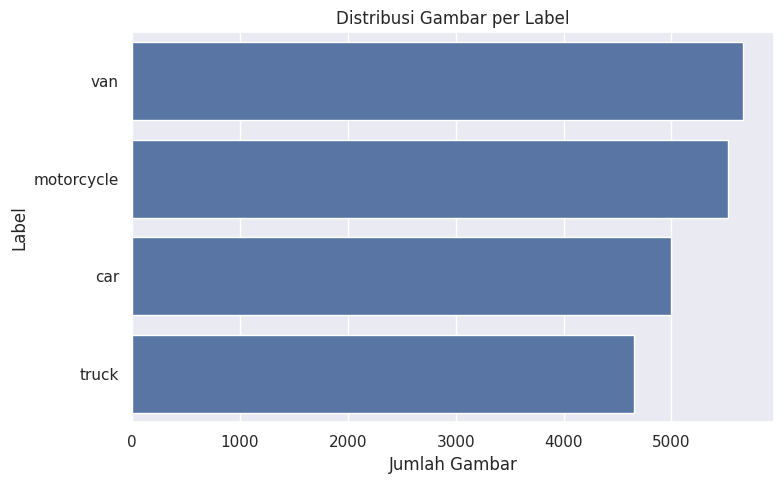

In [10]:
sns.set(style="darkgrid")

# Source path
vehicle_path = "vehicles_dataset/"

# List untuk menyimpan nama file, label, dan path lengkap
file_name = []
labels = []
full_path = []

# Looping ambil semua file gambar beserta labelnya
for path, subdirs, files in os.walk(vehicle_path):
    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))
            file_name.append(name)

# Membuat DataFrame
df = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

# Menghitung jumlah gambar per label
label_counts = df['labels'].value_counts()

# Plot distribusi dalam bentuk bar horizontal
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.values, y=label_counts.index)
plt.xlabel("Jumlah Gambar")
plt.ylabel("Label")
plt.title("Distribusi Gambar per Label")
plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [11]:
# Memanggil variabel mypath yang menampung folder dataset gambar
mypath= 'vehicles_dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
car,5000
motorcycle,5521
truck,4650
van,5667


In [12]:
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Membuat variabel input
X = df['path']
y = df['labels']

# Split menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300, stratify=y)

# Menggabungkan kembali ke dalam satu DataFrame
df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_test = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})
df_all = pd.concat([df_train, df_test], ignore_index=True)

# Distribusi data
print('Distribusi Data')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print(df_all.sample(5))

# Path asal dan tujuan
source_root = "vehicles_dataset"
target_root = "dataset_final"

# Proses penyalinan file berdasarkan hasil pembagian data
for idx, row in tqdm(df_all.iterrows(), total=len(df_all), desc="Copying files"):
    label = row['labels']
    set_type = row['set']
    original_path = row['path']

    # Coba langsung pakai path dari dataframe, kalau tidak ada coba bangun ulang path manual
    if not os.path.exists(original_path):
        filename = os.path.basename(original_path)
        original_path = os.path.join(source_root, label, filename)

    # Membuat folder tujuan
    target_folder = os.path.join(target_root, set_type, label)
    os.makedirs(target_folder, exist_ok=True)

    # Menentukan nama file tujuan
    file_name = os.path.basename(original_path)
    target_file_path = os.path.join(target_folder, file_name)

    # Menyalin file jika belum ada
    if not os.path.exists(target_file_path):
        shutil.copy2(original_path, target_file_path)

Distribusi Data
set    labels    
test   car           1000
       motorcycle    1104
       truck          930
       van           1134
train  car           4000
       motorcycle    4417
       truck         3720
       van           4533
dtype: int64 

                                               path      labels    set
6987      vehicles_dataset/van/van_augment_1242.jpg         van  train
14449  vehicles_dataset/motorcycle/images (83).jpeg  motorcycle  train
4999          vehicles_dataset/car/Image_001058.jpg         car  train
5075      vehicles_dataset/van/van_augment_2241.jpg         van  train
15368         vehicles_dataset/car/Image_009529.jpg         car  train


Copying files: 100%|██████████| 20838/20838 [00:05<00:00, 3556.11it/s]


In [13]:
import os

# Define training and test directories
TRAIN_DIR = "dataset_final/train/"
TEST_DIR = "dataset_final/test/"

# Paths for each label in the training and test set
train_van = os.path.join(TRAIN_DIR, 'van')
train_truck = os.path.join(TRAIN_DIR, 'truck')
train_motorcycle = os.path.join(TRAIN_DIR, 'motorcycle')
train_car = os.path.join(TRAIN_DIR, 'car')

test_van = os.path.join(TEST_DIR, 'van')
test_truck = os.path.join(TEST_DIR, 'truck')
test_motorcycle = os.path.join(TEST_DIR, 'motorcycle')
test_car = os.path.join(TEST_DIR, 'car')

# Total image training dan test set setiap kelas
print("Total number of van images in training set: ", len(os.listdir(train_van)))
print("Total number of truck images in training set: ", len(os.listdir(train_truck)))
print("Total number of motorcycle images in training set: ", len(os.listdir(train_motorcycle)))
print("Total number of car images in training set: ", len(os.listdir(train_car)))

print("Total number of van images in test set: ", len(os.listdir(test_van)))
print("Total number of truck images in test set: ", len(os.listdir(test_truck)))
print("Total number of motorcycle images in test set: ", len(os.listdir(test_motorcycle)))
print("Total number of car images in test set: ", len(os.listdir(test_car)))

Total number of van images in training set:  4533
Total number of truck images in training set:  3720
Total number of motorcycle images in training set:  4417
Total number of car images in training set:  4000
Total number of van images in test set:  1134
Total number of truck images in test set:  930
Total number of motorcycle images in test set:  1104
Total number of car images in test set:  1000


#### Image Data Generator

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat ImageDataGenerator
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Training data generator with RGB color mode
train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150, 150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

# Validation data generator with RGB color mode
validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150, 150),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

# Test data generator with RGB color mode
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150, 150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 13337 images belonging to 4 classes.
Found 3333 images belonging to 4 classes.
Found 4168 images belonging to 4 classes.


## Modelling

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

# Custom callback untuk menghentikan training jika accuracy dan val_accuracy > 0.95
class StopTrainingAtAccuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if acc and val_acc and acc > 0.95 and val_acc > 0.95:
            print(f"\nEpoch {epoch+1}: accuracy={acc:.4f}, val_accuracy={val_acc:.4f} > 0.95 — Training dihentikan.")
            self.model.stop_training = True

# Model CNN
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='sigmoid')  # Gunakan softmax jika label one-hot multiclass, sigmoid untuk multilabel
])

# Compile model langsung dengan optimizer Adam dan learning rate 0.0001
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # ganti ke 'categorical_crossentropy' jika multiclass
    metrics=['accuracy']
)

# Ringkasan arsitektur
model.summary()

# Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),
    StopTrainingAtAccuracy()
]

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,020 (1.55 MB)

 Trainable params: 405,124 (1.55 MB)

 Non-trainable params: 896 (3.50 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,020 (1.55 MB)

 Trainable params: 405,124 (1.55 MB)

 Non-trainable params: 896 (3.50 KB)

In [16]:
# Train model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6556 - loss: 0.4014

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


417/417 ━━━━━━━━━━━━━━━━━━━━ 43s 80ms/step - accuracy: 0.6559 - loss: 0.4011 - val_accuracy: 0.3954 - val_loss: 0.6839 - learning_rate: 1.0000e-04
Epoch 2/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.8511 - loss: 0.2071 - val_accuracy: 0.5764 - val_loss: 0.4439 - learning_rate: 1.0000e-04
Epoch 3/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - accuracy: 0.8749 - loss: 0.1683 - val_accuracy: 0.6862 - val_loss: 0.3099 - learning_rate: 1.0000e-04
Epoch 4/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.8805 - loss: 0.1573 - val_accuracy: 0.6367 - val_loss: 0.4492 - learning_rate: 1.0000e-04
Epoch 5/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.9006 - loss: 0.1363 - val_accuracy: 0.6466 - val_loss: 0.4111 - learning_rate: 1.0000e-04
Epoch 6/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.9128 - loss: 0.1185 - val_accuracy: 0.6148 - val_loss: 0.6329 - learning_rate: 1.0000e-04
Epoch 7/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - accurac

## Evaluasi dan Visualisasi

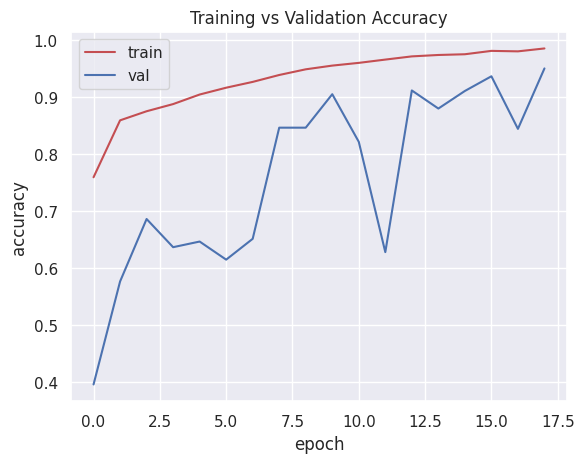

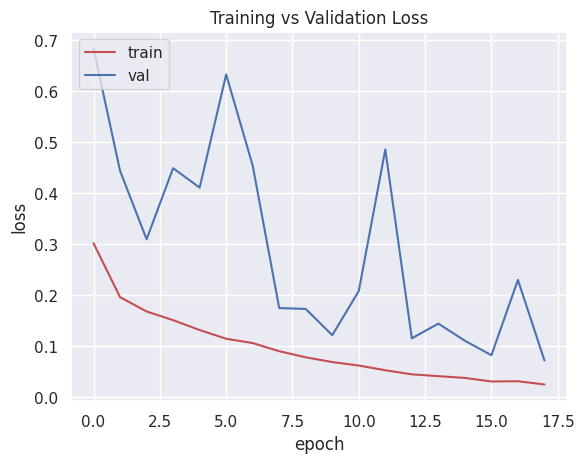

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot akurasi
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training vs Validation Loss')
plt.show()

In [18]:
# Evaluasi performa model di test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

4168/4168 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9852 - loss: 0.0260

Test Accuracy: 0.9818
Test Loss: 0.0331


4168/4168 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step


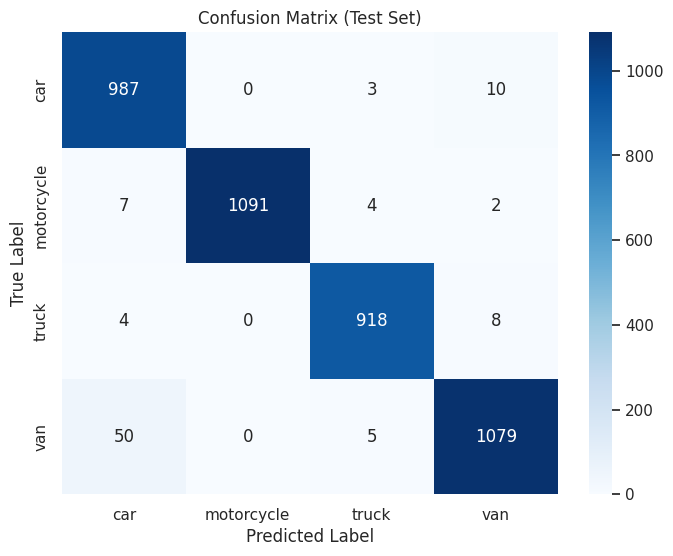

              precision    recall  f1-score   support

         car       0.94      0.99      0.96      1000
  motorcycle       1.00      0.99      0.99      1104
       truck       0.99      0.99      0.99       930
         van       0.98      0.95      0.97      1134

    accuracy                           0.98      4168
   macro avg       0.98      0.98      0.98      4168
weighted avg       0.98      0.98      0.98      4168



In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi di test set
y_pred = model.predict(test_generator)
y_pred_labels = np.where(y_pred > 0.5, 1, 0)  # untuk multilabel

# Label asli dari test set
y_true = test_generator.labels
class_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_labels.argmax(axis=1), target_names=class_names))

## Konversi Model

### SavedModel

In [20]:
import shutil
from google.colab import files
# Disimpan dalam format SavedModel
model.export('saved_model')

# Kompres folder saved_model jadi .zip
shutil.make_archive('saved_model', 'zip', 'saved_model')
files.download('saved_model.zip')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132880769504976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132880387814416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132880387805776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132880387806352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132880387815760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132880387806160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132880769504784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132880387816336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132880387810192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132880387809808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132880387804624: Te

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TF-Lite

In [21]:
# Konversi model ke TensorFlow Lite (.tflite)
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Simpan model TFLite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Kompres file TFLite menjadi .zip
shutil.make_archive('model_tflite', 'zip', '.', 'model.tflite')
files.download('model_tflite.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TFJS

In [22]:
!pip install tensorflowjs
import tensorflowjs as tfjs

# Konversi model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, 'model_tfjs')

# Kompres folder model_tfjs menjadi .zip
shutil.make_archive('model_tfjs', 'zip', 'model_tfjs')
files.download('model_tfjs.zip')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference Menggunakan SavedModel


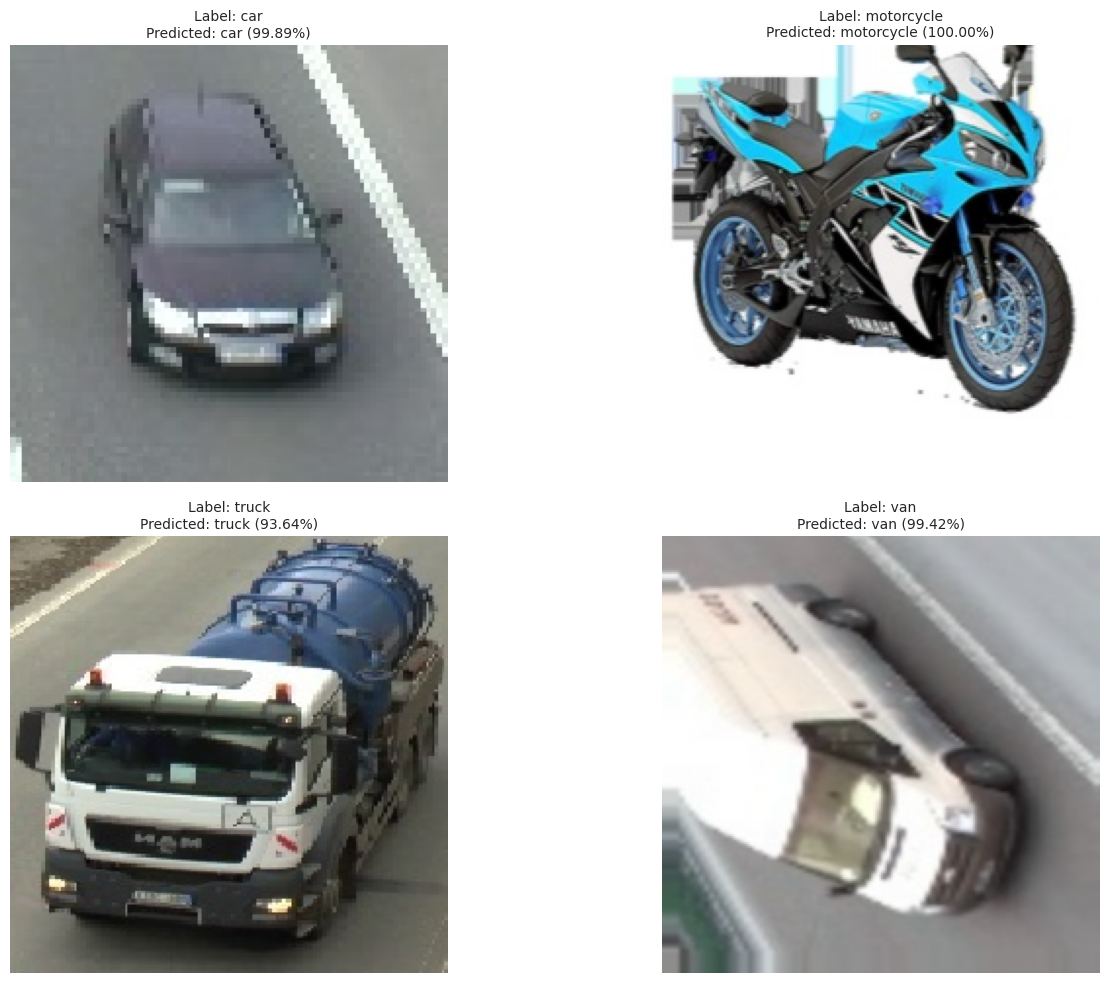

In [70]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from keras.layers import TFSMLayer

# Load model
model = TFSMLayer('saved_model', call_endpoint='serving_default')

# Label kelas
class_names = list(train_generator.class_indices.keys())

# Path folder utama
folder_path = 'dataset_final/test'

# Dictionary untuk simpan gambar per kelas
images_per_class = {label: [] for label in class_names}

# Mengambil semua gambar dari masing-masing folder label
for label in class_names:
    label_folder = os.path.join(folder_path, label)
    if os.path.exists(label_folder):
        for file in os.listdir(label_folder):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                images_per_class[label].append(os.path.join(label_folder, file))

# Mengecek apakah semua label punya gambar
for label in class_names:
    if len(images_per_class[label]) == 0:
        print(f"Tidak ada gambar untuk label '{label}'!")
        exit()

# Memilih 1 gambar random dari masing-masing label
selected_images = []
for label in class_names:
    selected_img = random.choice(images_per_class[label])
    selected_images.append((label, selected_img))

# Plot
plt.figure(figsize=(15,10))

for i, (true_label, img_path) in enumerate(selected_images):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Inference
    output = model(img_array)
    predictions = list(output.values())[0].numpy().flatten()

    # Cari prediksi dengan nilai tertinggi
    pred_idx = np.argmax(predictions)
    pred_label = class_names[pred_idx]
    pred_confidence = predictions[pred_idx] * 100  # persen

    # Plot gambar dan hasil prediksi
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Label: {true_label}\nPredicted: {pred_label} ({pred_confidence:.2f}%)", fontsize=10)

plt.tight_layout()
plt.show()


In [24]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.21.0.37.6
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.1.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.1
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confect